Epoch 1: Train Loss=0.1677, Val Loss=0.1588
Epoch 2: Train Loss=0.1593, Val Loss=0.1514
Epoch 3: Train Loss=0.1566, Val Loss=0.1495
Epoch 4: Train Loss=0.1510, Val Loss=0.1445
Epoch 5: Train Loss=0.1463, Val Loss=0.1434
Epoch 6: Train Loss=0.1444, Val Loss=0.1415
Epoch 7: Train Loss=0.1433, Val Loss=0.1408
Epoch 8: Train Loss=0.1421, Val Loss=0.1391
Epoch 9: Train Loss=0.1418, Val Loss=0.1387
Epoch 10: Train Loss=0.1413, Val Loss=0.1440
Epoch 11: Train Loss=0.1399, Val Loss=0.1381
Epoch 12: Train Loss=0.1398, Val Loss=0.1367
Epoch 13: Train Loss=0.1386, Val Loss=0.1370
Epoch 14: Train Loss=0.1382, Val Loss=0.1372
Epoch 15: Train Loss=0.1375, Val Loss=0.1364
Epoch 16: Train Loss=0.1373, Val Loss=0.1358
Epoch 17: Train Loss=0.1365, Val Loss=0.1357
Epoch 18: Train Loss=0.1362, Val Loss=0.1358
Epoch 19: Train Loss=0.1359, Val Loss=0.1351
Epoch 20: Train Loss=0.1356, Val Loss=0.1362
✅ Best model saved.


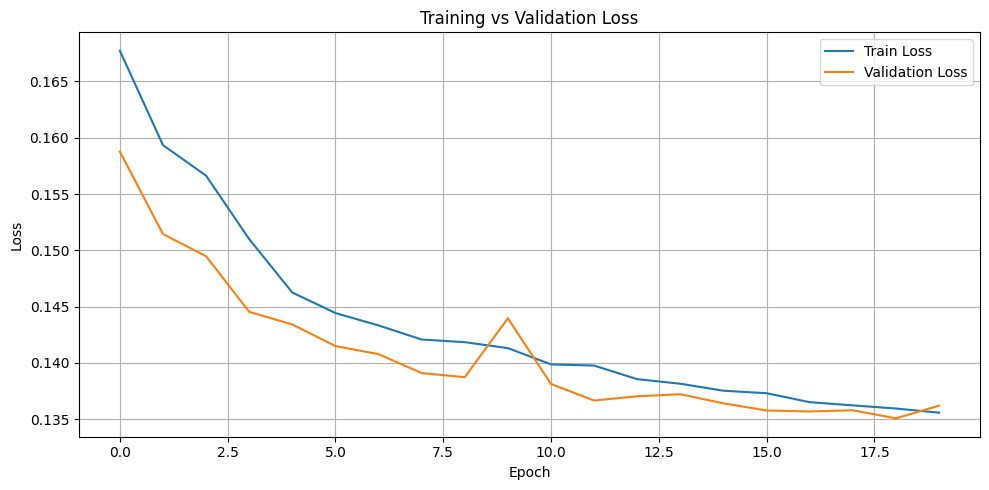

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv("./DATA/data1day.csv")
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'])

# 2. Create label
df['performance_issue'] = (df['AVG_PROCESSING_TIME_MINUTES'] > 10).astype(int)

# 3. Encode CHUTE and ZIP_CODE
df['CHUTE'] = df['CHUTE'].astype('category').cat.codes
df['ZIP_CODE'] = df['ZIP_CODE'].astype('category').cat.codes

# 4. Sort chronologically
df = df.sort_values(by=['CHUTE', 'ZIP_CODE', 'HOUR_TIME']).reset_index(drop=True)

# 5. Add engineered features
df['chute_load'] = df.groupby(['CHUTE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
df['zip_package_count'] = df.groupby(['ZIP_CODE', 'HOUR_TIME'])['PACKAGE_COUNT'].transform('sum')
df['hour_of_day'] = df['HOUR_TIME'].dt.hour
df['day_of_week'] = df['HOUR_TIME'].dt.dayofweek  # Monday = 0

# 6. Define features and targets
features = [
    'CODS_ZENT_NR', 'CHUTE', 'ZIP_CODE', 'PACKAGE_COUNT',
    'chute_load', 'zip_package_count', 'hour_of_day', 'day_of_week'
]
target_reg = 'AVG_PROCESSING_TIME_MINUTES'
target_cls = 'performance_issue'

# 7. Normalize
feature_scaler = MinMaxScaler()
df[features] = feature_scaler.fit_transform(df[features])

target_scaler = MinMaxScaler()
df[[target_reg]] = target_scaler.fit_transform(df[[target_reg]])

# 8. Create sequences for LSTM
def create_sequences(data, target_reg_idx, target_cls_idx, seq_len=5):
    X, y_reg, y_cls = [], [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-2])
        y_reg.append(data[i+seq_len, target_reg_idx])
        y_cls.append(data[i+seq_len, target_cls_idx])
    return np.array(X), np.array(y_reg), np.array(y_cls)

data = df[features + [target_reg, target_cls]].values
X, y_reg, y_cls = create_sequences(data, len(features), len(features)+1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg, dtype=torch.float32)
y_cls_tensor = torch.tensor(y_cls, dtype=torch.float32)

# 9. Create DataLoaders
dataset = TensorDataset(X_tensor, y_reg_tensor, y_cls_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# 10. Define LSTM Hybrid Model
class LSTMHybrid(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc_reg = nn.Linear(hidden_size, 1)
        self.fc_cls = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc_reg(out), self.sigmoid(self.fc_cls(out))

model = LSTMHybrid(input_size=X.shape[2])
criterion_reg = nn.MSELoss()
criterion_cls = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 11. Train model
train_losses, val_losses = [], []
best_val_loss = float("inf")
best_model_state = None

for epoch in range(20):
    model.train()
    train_loss = 0
    for xb, yb_reg, yb_cls in train_loader:
        optimizer.zero_grad()
        out_reg, out_cls = model(xb)
        loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb_reg, yb_cls in val_loader:
            out_reg, out_cls = model(xb)
            loss = criterion_reg(out_reg.view(-1), yb_reg) + criterion_cls(out_cls.view(-1), yb_cls)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

# 12. Save model
torch.save(best_model_state, "best_lstm_hybrid.pt")
print("✅ Best model saved.")

# 13. Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
performance_issue = df["AVG_PROCESSING_TIME_MINUTES"] > 10


NameError: name 'df' is not defined

Epoch 1: Train Loss=0.1677, Val Loss=0.1672
Epoch 2: Train Loss=0.1586, Val Loss=0.1663
Epoch 3: Train Loss=0.1552, Val Loss=0.1601
Epoch 4: Train Loss=0.1495, Val Loss=0.1563
Epoch 5: Train Loss=0.1477, Val Loss=0.1573
Epoch 6: Train Loss=0.1473, Val Loss=0.1558
Epoch 7: Train Loss=0.1471, Val Loss=0.1539
Epoch 8: Train Loss=0.1462, Val Loss=0.1533
Epoch 9: Train Loss=0.1456, Val Loss=0.1548
Epoch 10: Train Loss=0.1454, Val Loss=0.1524
Epoch 11: Train Loss=0.1448, Val Loss=0.1533
Epoch 12: Train Loss=0.1445, Val Loss=0.1522
Epoch 13: Train Loss=0.1440, Val Loss=0.1526
Epoch 14: Train Loss=0.1440, Val Loss=0.1513
Epoch 15: Train Loss=0.1437, Val Loss=0.1516
Epoch 16: Train Loss=0.1432, Val Loss=0.1526
Epoch 17: Train Loss=0.1431, Val Loss=0.1508
Epoch 18: Train Loss=0.1426, Val Loss=0.1509
Epoch 19: Train Loss=0.1426, Val Loss=0.1509
Epoch 20: Train Loss=0.1424, Val Loss=0.1501


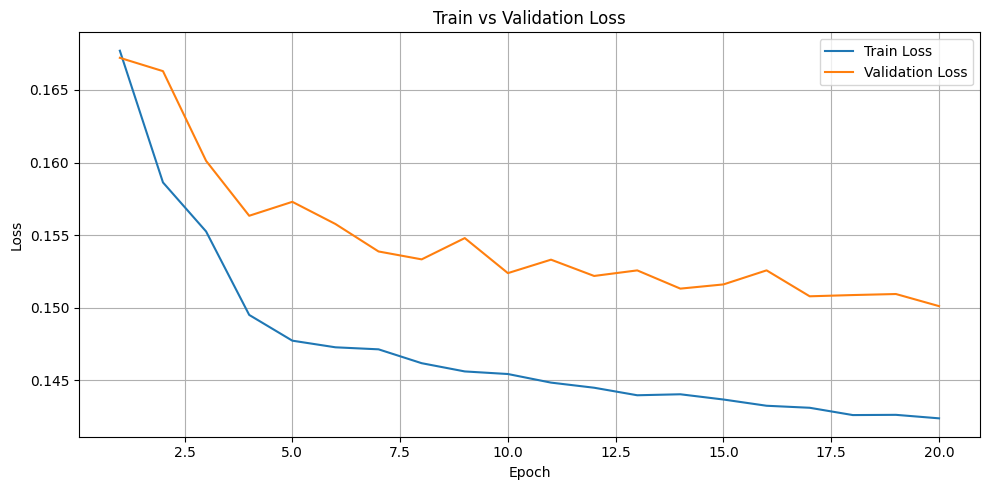